## Starting the amazon sustainability data challenge

In [3]:
import os
with open("pip_requirements.txt", mode='a'):
    pass
%pip install boto3        -r pip_requirements.txt | grep -v 'already satisfied'
%pip install pandas       -r pip_requirements.txt | grep -v 'already satisfied'
%pip install numpy        -r pip_requirements.txt | grep -v 'already satisfied'
%pip install requests     -r pip_requirements.txt | grep -v 'already satisfied'
%pip install ipywidgets   -r pip_requirements.txt | grep -v 'already satisfied'
%pip install scikit-learn -r pip_requirements.txt | grep -v 'already satisfied'
%pip install autogluon    -r pip_requirements.txt | grep -v 'already satisfied'
%pip install matplotlib   -r pip_requirements.txt | grep -v 'already satisfied'
%pip install nbconvert    -r pip_requirements.txt | grep -v 'already satisfied'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Import statements for packages used...
import os, glob, shutil, sys, requests, json
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from botocore import UNSIGNED
from botocore.config import Config
from io import StringIO
from datetime import datetime
from types import SimpleNamespace
from IPython.display import clear_output

# The following is required for matplotlib plots to display in some envs...
%matplotlib inline

## The utils file contain important classes including:
1. AQParam => used to define attributes for the main OpenAQ parameters such as pm10, pm25, no2, co, so2, o3.
2. AQScenario => used to define the machine learning scenario incuding a location w/ NOAA weather station ID and the target OpenAQ Param.
3. AQbyWeatherApp => this is the main class with settings, AQParams, AQScenarios, and the data query methods ............

**To review the methods, please open the utils file in the main directory**

In [23]:
%run utils

Classes and Variables are ready.


In [12]:
#1 Instantiating the main app
AQbyWeather = AQbyWeatherApp(mlTargetLabel='isUnhealthy', mlEvalMetric='accuracy')

#2 Setting the default threshold for the six parameters as provided in https://www.epa.gov/criteria-air-pollutants/naaqs-table
#  where a primary and secondary standard is defined  for pollutant, the threshold level defined for the primary is selected
AQbyWeather.addAQParam(AQParam( 1, "pm10", "µg/m³", 150.0, "Particulate Matter < 10 micrometers"))
AQbyWeather.addAQParam(AQParam( 2, "pm25", "µg/m³",  12.0, "Particulate Matter < 2.5 micrometers"))
AQbyWeather.addAQParam(AQParam( 7, "no2",  "ppm",   100.0, "Nitrogen Dioxide"))
AQbyWeather.addAQParam(AQParam( 8, "co",   "ppm",     9.0, "Carbon Monoxide"))
AQbyWeather.addAQParam(AQParam( 9, "so2",  "ppm",    75.0, "Sulfur Dioxide"))
AQbyWeather.addAQParam(AQParam(10, "o3",   "ppm",   0.070, "Ground Level Ozone"))

#3 creating scenarios 
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm10"], None)) # Attempt at pm10 prediction.
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("fresno",      "72389093193", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("fresno",      "72389093193", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("visalia",     "72389693144", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("visalia",     "72389693144", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("san-jose",    "72494693232", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("san-jose",    "72494693232", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("phoenix",     "72278023183", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("phoenix",     "72278023183", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("fairbanks",   "70261026411", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("lahore-pk",   "41640099999", AQbyWeather.aqParams["pm25"], None))

print(f"AQbyWeather.aqParams: {str(len(AQbyWeather.aqParams))}")
print(f"AQbyWeather.aqScenarios: {str(len(AQbyWeather.aqScenarios))} (Default Selected: {AQbyWeather.selectedScenario.name})")

AQbyWeather.aqParams: 6
AQbyWeather.aqScenarios: 15 (Default Selected: bakersfield_pm25)


In [13]:
# CELL #5: Select a Scenario via DROP DOWN LIST to use throughout the Notebook. This will drive the ML process...
# A default "value" is set to avoid issues. Change this default to run the Notebook from start-to-finish for that Scenario.
print("*** CHOOSE YOUR OWN ADVENTURE HERE ***")
print("Please select a Scenario via the following drop-down-list...")
print("(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)")
ddl = widgets.Dropdown(options=AQbyWeather.aqScenarios.keys(), 
                       value=AQbyWeather.aqScenarios["bakersfield_pm25"].name) # <-- DEFAULT / FULL-RUN VALUE
ddl

*** CHOOSE YOUR OWN ADVENTURE HERE ***
Please select a Scenario via the following drop-down-list...
(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)


Dropdown(options=('bakersfield_pm25', 'bakersfield_pm10', 'bakersfield_o3', 'fresno_pm25', 'fresno_o3', 'visal…

In [130]:
if ddl.value:
    AQbyWeather.selectedScenario = AQbyWeather.aqScenarios[ddl.value]
    print(AQbyWeather.selectedScenario.getSummary())
    print(AQbyWeather.selectedScenario.toJSON())
else:
    print("Please select a Scenario via the above drop-down-list.")

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm
{
  "aqParamTarget": {
    "desc": "Ground Level Ozone",
    "id": 10,
    "name": "o3",
    "unhealthyThresholdDefault": 0.07,
    "unit": "ppm"
  },
  "aqRadiusMeters": 16100,
  "aqRadiusMiles": 10,
  "location": "visalia",
  "modelFolder": "AutogluonModels",
  "name": "visalia_o3",
  "noaaStationID": "72389693144",
  "noaaStationLat": 0.0,
  "noaaStationLng": 0.0,
  "openAqLocIDs": [],
  "unhealthyThreshold": 0.035,
  "yearEnd": 2022,
  "yearStart": 2016
}


In [131]:
# GET NOAA GSOD WEATHER DATA...
print(AQbyWeather.selectedScenario.getSummary())
noaagsod_df = AQbyWeather.getNoaaDataFrame()

if(len(noaagsod_df) >= 1):
    # Update NOAA Station Lat/Lng...
    AQbyWeather.selectedScenario.updateNoaaStationLatLng(noaagsod_df.iloc[0])
    
    # Save DataFrame to CSV...
    PATH = ddl.value
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    noaagsod_df.to_csv(PATH+"/"+AQbyWeather.getFilenameNOAA(), index=False)

    # Output DataFrame properties...
    print('noaagsod_df.shape =', noaagsod_df.shape)
    display(noaagsod_df)

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm
Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: noaa-gsod-pds)...
NOAA Station Lat,Lng Updated for Scenario: visalia_o3 => 36.31667,-119.4
noaagsod_df.shape = (2407, 10)


,DATE,NAME,LATITUDE,LONGITUDE,DEWP,WDSP,MAX,MIN,PRCP,MONTH
0,2016-01-01,"VISALIA MUNICIPAL AIRPORT, CA US",36.31667,-119.4,32.7,1.2,52.0,26.1,0.00,1
1,2016-01-02,"VISALIA MUNICIPAL AIRPORT, CA US",36.31667,-119.4,36.1,1.7,52.0,26.1,0.00,1
2,2016-01-03,"VISALIA MUNICIPAL AIRPORT, CA US",36.31667,-119.4,38.7,2.7,59.0,35.1,0.00,1
3,2016-01-04,"VISALIA MUNICIPAL AIRPORT, CA US",36.31667,-119.4,37.6,1.9,55.0,33.8,0.00,1
4,2016-01-05,"VISALIA MUNICIPAL AIRPORT, CA US",36.31667,-119.4,46.3,6.3,55.0,34.0,0.03,1
...,...,...,...,...,...,...,...,...,...,...
2402,2022-07-30,"VISALIA MUNICIPAL AIRPORT, CA US",36.31667,-119.4,63.3,4.6,102.9,70.0,0.00,7
2403,2022-07-31,"VISALIA MUNICIPAL AIRPORT, CA US",36.31667,-119.4,62.7,4.7,102.9,72.0,0.00,7
2404,2022-08-01,"VISALIA MUNICIPAL AIRPORT, CA US",36.31667,-119.4,64.4,5.3,99.0,75.0,0.00,8
2405,2022-08-02,"VISALIA MUNICIPAL AIRPORT, CA US",36.31667,-119.4,61.4,5.6,99.0,70.0,0.00,8


In [132]:
# GET OPENAQ AIR QUALITY DAILY AVERAGES DATA...
print(AQbyWeather.selectedScenario.getSummary())
aq_df = AQbyWeather.getOpenAqDataFrame() # Gets nearby Location IDs THEN gets associated daily averages.
    
if len(aq_df) > 0:
    # Output DataFrame properties...
    print('aq_df.shape =', aq_df.shape)
    display(aq_df)
    aq_df.to_csv(PATH+"/"+AQbyWeather.getFilenameOpenAQ(), index=False)

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm
Accessing ASDI-hosted OpenAQ Locations (HTTPS API)...
OpenAQ Location IDs within 10 miles (16100m) of NOAA Station 72389693144 at 36.31667,-119.4: [8896, 288307, 28692, 877]
Accessing ASDI-hosted OpenAQ Averages (HTTPS API)...
aq_df.shape = (2186, 5)


,day,parameter,unit,average,isUnhealthy
0,2016-03-06,o3,ppm,0.0400,1
1,2016-03-10,o3,ppm,0.0085,0
2,2016-03-11,o3,ppm,0.0194,0
3,2016-03-12,o3,ppm,0.0258,0
4,2016-03-13,o3,ppm,0.0207,0
...,...,...,...,...,...
2181,2022-08-26,o3,ppm,0.0468,1
2182,2022-08-27,o3,ppm,0.0396,1
2183,2022-08-28,o3,ppm,0.0404,1
2184,2022-08-29,o3,ppm,0.0431,1


Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm
merged_df.shape = (2159, 7)


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,isUnhealthy
0,51.6,8.7,66.0,51.1,0.53,3,1
1,50.3,2.8,78.1,43.0,0.00,3,0
2,50.7,5.2,78.1,48.0,0.26,3,0
3,45.6,2.8,61.0,43.0,0.01,3,0
4,47.0,4.9,62.1,43.0,0.02,3,0
...,...,...,...,...,...,...,...
2154,63.3,4.6,102.9,70.0,0.00,7,1
2155,62.7,4.7,102.9,72.0,0.00,7,1
2156,64.4,5.3,99.0,75.0,0.00,8,0
2157,61.4,5.6,99.0,70.0,0.00,8,1


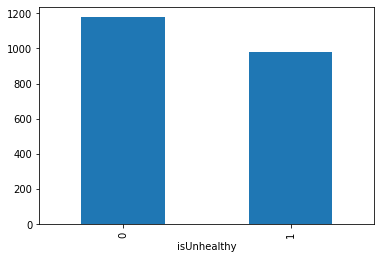

In [133]:
# Merging the NOAA GSOD weather data with the OpenAQ data by DATE...
# Peforming more column filtering 

print(AQbyWeather.selectedScenario.getSummary())
merged_df = AQbyWeather.getMergedDataFrame(noaagsod_df, aq_df)

if(len(merged_df > 0)):
    # Output DataFrame properties...
    print('merged_df.shape =', merged_df.shape)
    display(merged_df)
    merged_df.groupby([AQbyWeather.mlTargetLabel]).size().plot(kind="bar")
    merged_df.to_csv(PATH+"/"+AQbyWeather.getFilenameOther("dataMERGED"), index=False)


Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm


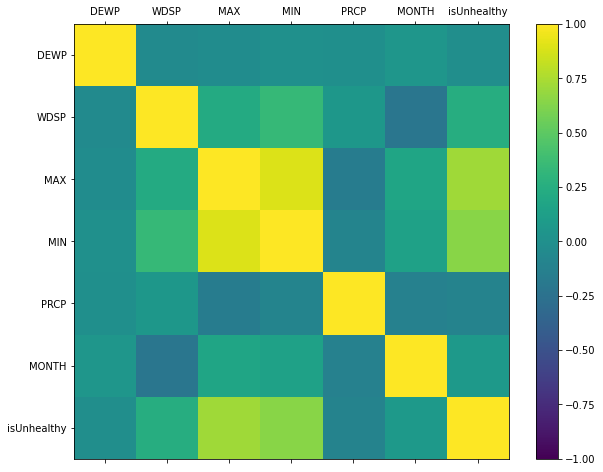

In [134]:
# Visualize correlations in our merged dataframe...
print(AQbyWeather.selectedScenario.getSummary())
correlations = merged_df.corr()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(merged_df.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(merged_df.columns)
ax.set_yticklabels(merged_df.columns)
plt.show()

## **Starting ML on the MERGED Dataframe**



In [135]:
# Additional import statements for autogluon+sklearn and split out train_df + validate_df data...
print(AQbyWeather.selectedScenario.getSummary())
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_df, validate_df = train_test_split(merged_df, test_size=0.33, random_state=1)
print('Number of training samples:', len(train_df))
print('Number of validation samples:', len(validate_df))

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm
Number of training samples: 1446
Number of validation samples: 713


In [136]:
# Create the test_df (or holdout) data and remove the target label column...
print(AQbyWeather.selectedScenario.getSummary())
test_df=validate_df.drop([AQbyWeather.mlTargetLabel], axis=1)
display(test_df)

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm


,DEWP,WDSP,MAX,MIN,PRCP,MONTH
986,40.5,8.6,57.0,41.0,99.99,2
389,41.3,3.5,69.1,37.0,0.00,4
65,56.5,5.4,96.1,60.1,0.00,5
134,54.4,4.5,97.0,57.9,0.00,7
712,37.4,5.6,62.1,37.0,0.00,3
...,...,...,...,...,...,...
807,54.1,6.2,91.9,60.1,0.00,6
51,46.3,3.7,82.0,46.0,0.00,4
900,50.4,3.3,80.1,52.0,0.00,10
943,33.5,2.3,54.0,28.9,0.00,12


## **Running AutoGluon TabularPredictor.fit() to fit the models**

In [137]:
# Use AutoGluon TabularPredictor to fit a model for our training data...
display(AQbyWeather.selectedScenario.getSummary()) #Using display for consistent/sequential output order.
predictor = TabularPredictor(label=AQbyWeather.mlTargetLabel, 
                             eval_metric=AQbyWeather.mlEvalMetric, 
                             path=AQbyWeather.selectedScenario.getModelPath())
predictor.fit(train_data=train_df, time_limit=AQbyWeather.mlTimeLimitSecs, verbosity=2, presets='best_quality')

'Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm'

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/aq_visalia_o3_2016-2022/"
AutoGluon Version:  0.5.2
Python Version:     3.9.13
Operating System:   Linux
Train Data Rows:    1446
Train Data Columns: 6
Label Column: isUnhealthy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    14613.06 MB
	Train Data (Original)  Memory Usage: 0.07 MB (0.0% 

## **Evaluating the model**
* Calculating the feature importances and displaying a leaderboard.

In [138]:
# Get dataframes for feature importance + model leaderboard AND get+display model evaluation...
display(AQbyWeather.selectedScenario.getSummary()) #Using display for consistent/sequential output order.
featureimp_df   = predictor.feature_importance(validate_df)
leaderboard_df  = predictor.leaderboard(validate_df, silent=True)
modelEvaluation = predictor.evaluate(validate_df, auxiliary_metrics=True)

'Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm'

Computing feature importance via permutation shuffling for 6 features using 713 rows with 5 shuffle sets...
	22.16s	= Expected runtime (4.43s per shuffle set)
	3.64s	= Actual runtime (Completed 5 of 5 shuffle sets)
Evaluation: accuracy on test data: 0.8625525946704067
Evaluations on test data:
{
    "accuracy": 0.8625525946704067,
    "balanced_accuracy": 0.8654148801207624,
    "mcc": 0.724905347507119,
    "roc_auc": 0.9351062292238762,
    "f1": 0.846875,
    "precision": 0.811377245508982,
    "recall": 0.8856209150326797
}


In [139]:
# View Autogluon Individual Model Leaderboard...
print(AQbyWeather.selectedScenario.getSummary())
display(leaderboard_df)

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost_BAG_L1,0.862553,0.872061,0.011907,0.095560,6.586504,0.011907,0.095560,6.586504,1,True,7
1,NeuralNetTorch_BAG_L1,0.862553,0.867220,0.128190,0.099230,14.103426,0.128190,0.099230,14.103426,1,True,12
2,WeightedEnsemble_L2,0.862553,0.873444,0.405721,0.470596,15.353968,0.007729,0.002664,1.175327,2,True,14
3,LightGBMXT_BAG_L1,0.859748,0.866528,0.052567,0.021296,5.997272,0.052567,0.021296,5.997272,1,True,3
4,NeuralNetFastAI_BAG_L1,0.859748,0.870678,0.208758,0.140232,13.020192,0.208758,0.140232,13.020192,1,True,10
5,ExtraTreesGini_BAG_L1,0.854137,0.861687,0.155664,0.154534,0.712742,0.155664,0.154534,0.712742,1,True,8
6,LightGBM_BAG_L1,0.852735,0.866528,0.073543,0.030619,6.553870,0.073543,0.030619,6.553870,1,True,4
7,ExtraTreesEntr_BAG_L1,0.851332,0.858230,0.177854,0.196543,0.882123,0.177854,0.196543,0.882123,1,True,9
8,XGBoost_BAG_L1,0.848527,0.862379,0.077698,0.058759,4.460876,0.077698,0.058759,4.460876,1,True,11
9,LightGBMLarge_BAG_L1,0.848527,0.865837,0.086957,0.021124,7.719051,0.086957,0.021124,7.719051,1,True,13


Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm


,importance,stddev,p_value,n,p99_high,p99_low
MAX,0.339130,0.018458,0.000001,5,0.377136,0.301125
DEWP,0.022440,0.005522,0.000407,5,0.033810,0.011071
WDSP,0.018233,0.004089,0.000284,5,0.026652,0.009813
MONTH,0.012623,0.003967,0.001031,5,0.020791,0.004455
MIN,0.003647,0.001882,0.006159,5,0.007521,-0.000228
PRCP,0.003086,0.001829,0.009777,5,0.006851,-0.000680


<AxesSubplot:xlabel='feature'>

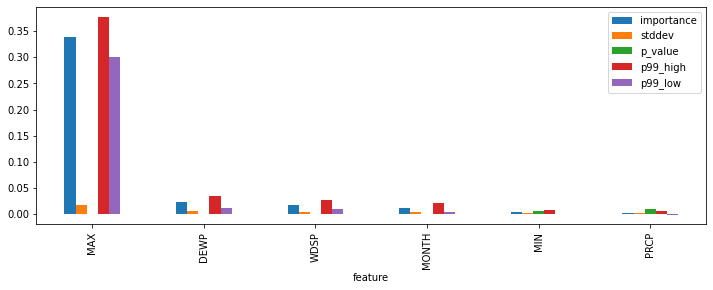

In [140]:
# View and Plot Feature Importance... (this vary for the different scenarios)
print(AQbyWeather.selectedScenario.getSummary())
display(featureimp_df)
featureimp_df.drop(columns=["n"]).plot(kind="bar", figsize=(12, 4), xlabel="feature")

## **Testing the model**

In [141]:
predictor = TabularPredictor.load(AQbyWeather.selectedScenario.getModelPath())

# Make Predictions, which are saved to an array: y_pred
print(AQbyWeather.selectedScenario.getSummary())
y_pred = predictor.predict(test_df)
display(y_pred)

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm


986     0
389     0
65      1
134     1
712     0
       ..
807     1
51      1
900     0
943     0
1017    0
Name: isUnhealthy, Length: 713, dtype: int64

In [142]:
# Get true label values as an array: y_true
print(AQbyWeather.selectedScenario.getSummary())
y_true = validate_df[AQbyWeather.mlTargetLabel]
display(y_true)

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm


986     0
389     0
65      1
134     1
712     1
       ..
807     1
51      0
900     0
943     0
1017    0
Name: isUnhealthy, Length: 713, dtype: int64

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm
True Negatives  (TN): 344 of 407 => 84.52%
True Positives  (TP): 271 of 306 => 88.56%
False Negatives (FN): 35 of 306 => 11.44%
False Positives (FP): 63 of 407 => 15.48%


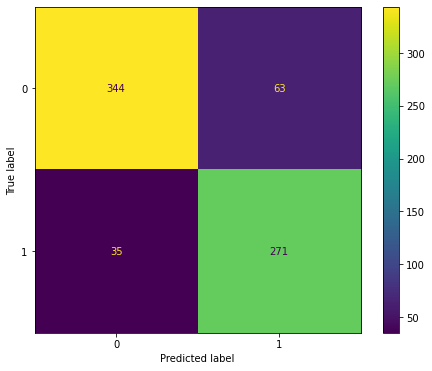

In [143]:
print(AQbyWeather.selectedScenario.getSummary())
cm = confusion_matrix(y_true, y_pred)

# Print Confusion Matrix data...
cmData = AQbyWeather.getConfusionMatrixData(cm)
print(cmData.TN_Output)
print(cmData.TP_Output)
print(cmData.FN_Output)
print(cmData.FP_Output)

# Plot Confusion Matrix...
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax)

In [144]:
# Create and save final results...
print(AQbyWeather.selectedScenario.getSummary())
resultsFile = AQbyWeather.getFilenameOther("dataRESULTS")
results_df = pd.DataFrame()
results_df['PREDICTION'] = pd.DataFrame(y_pred)
results_df = pd.concat([validate_df, results_df], axis=1)
results_df.to_csv(PATH+"/"+resultsFile, index=False)
print(f"Results saved to {resultsFile}. DONE.")
display(results_df)

Scenario: visalia_o3 => Ground Level Ozone (o3) with UnhealthyThreshold > 0.035 ppm
Results saved to dataRESULTS_visalia_o3_2016-2022.csv. DONE.


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,isUnhealthy,PREDICTION
986,40.5,8.6,57.0,41.0,99.99,2,0,0
389,41.3,3.5,69.1,37.0,0.00,4,0,0
65,56.5,5.4,96.1,60.1,0.00,5,1,1
134,54.4,4.5,97.0,57.9,0.00,7,1,1
712,37.4,5.6,62.1,37.0,0.00,3,1,0
...,...,...,...,...,...,...,...,...
807,54.1,6.2,91.9,60.1,0.00,6,1,1
51,46.3,3.7,82.0,46.0,0.00,4,0,1
900,50.4,3.3,80.1,52.0,0.00,10,0,0
943,33.5,2.3,54.0,28.9,0.00,12,0,0


In [147]:
AQbyWeather.selectedScenario.getModelPath()

'AutogluonModels/aq_visalia_o3_2016-2022/'

In [154]:
import pickle

In [172]:
pred1 = pickle.load(open("AutogluonModels/aq_visalia_o3_2016-2022/learner.pkl", "rb"))

In [174]:
test_df.head()

,DEWP,WDSP,MAX,MIN,PRCP,MONTH
986,40.5,8.6,57.0,41.0,99.99,2
389,41.3,3.5,69.1,37.0,0.00,4
65,56.5,5.4,96.1,60.1,0.00,5
134,54.4,4.5,97.0,57.9,0.00,7
712,37.4,5.6,62.1,37.0,0.00,3


In [180]:
k = pred1.predict(pd.DataFrame({"DEWP":[40.5],"WDSP":[8.6],"MAX":[57.0],"MIN":[41.0],"PRCP":[99.99],"MONTH":[2]}))

In [186]:
def predict_state(data):
    scenario = int(input("Please specify the scenario\n Enter:\n 1 for Visala_pm2.5\n 2 for visalla_o3\n 3 for aq_fresno_pm2.5\n 4 for aq_fresno_o3\n 5 for aq_bakersfield_pm10\n 6 for aq_bakersfield_o3\n Enter it here: "))
    models = ["select_models/visala_pm25.pkl", "select_models/visala_o3.pkl", "select_models/aq_fresno_pm25.pkl", "select_models/aq_fresno_o3.pkl", "select_models/aq_bakersfield_pm25.pkl", "select_models/aq_bakersfield_pm10.pkl", "select_models/aq_bakersfield_o3.pkl"]
    data = pd.DataFrame(data)
    model = pickle.load(open(models[scenario-1], "rb"))
    prediction = model.predict(data)[0]
    value = {0: "healthy", 1: "unhealthy"}
    return f"the air quality is {value[prediction]}"
    
    
                   

In [187]:
predict_state({"DEWP":[40.5],"WDSP":[8.6],"MAX":[57.0],"MIN":[41.0],"PRCP":[99.99],"MONTH":[2]})

Please specify the scenario
 Enter:
 1 for Visala_pm2.5
 2 for visalla_o3
 3 for aq_fresno_pm2.5
 4 for aq_fresno_o3
 5 for aq_bakersfield_pm10
 6 for aq_bakersfield_o3
 Enter it here:  1


'the air quality is healthy'